In [1]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices' ## enable xla devices
!nvidia-smi ## check Nvidia GPU details
# !nvidia-smi -L
# !nvidia-smi -q
!lscpu
# !lscpu |grep 'Model name' ## Check CPU details
# !lscpu |grep 'Number of Socket(s):'
# !lscpu | grep 'Core(s) each processor has/per socket:'
# !lscpu | grep 'Number of threads/core:'
!free -h --si | awk  '/Mem:/{print $2}'

# if use tpu
# import tensorflow as tf
# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.TPUStrategy(tpu)

/bin/bash: /tmp/ENTER/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Fri Nov  4 18:22:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.76       Driver Version: 515.76       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:2D:00.0 Off |                  Off |
| 30%   32C    P8    20W / 230W |     22MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+------

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=28)
mpl.rc('xtick', labelsize=24)
mpl.rc('ytick', labelsize=24)

import math
import time 
# from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

2022-11-04 18:22:43.096239: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-04 18:22:43.198847: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-04 18:22:43.227711: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-04 18:22:43.733284: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [3]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [4]:
is_gpu = len(tf.config.list_physical_devices('GPU')) > 0 
print(is_gpu)

True


# CFD Parameters

In [5]:
dt = 0.5
dx = 1.0
dy = 1.0
dz = 1.0
Re = 1/20
ub = 1
nx = 1024
ny = 1024
nz = 128
ratio = int(nx/nz)
nlevel = int(math.log(nz, 2)) + 1 
print('Levels of Multigrid:', nlevel)
print('Aspect ratio of Domain:', ratio)

Levels of Multigrid: 8
Aspect ratio of Domain: 8


# Weights of CNNs layers

In [6]:
pd1 = [[2/26, 3/26,  2/26],
       [3/26, 6/26,  3/26],
       [2/26, 3/26,  2/26]]
pd2 = [[3/26, 6/26,  3/26],
       [6/26, -88/26, 6/26],
       [3/26, 6/26,  3/26]]
pd3 = [[2/26, 3/26,  2/26],
       [3/26, 6/26,  3/26],
       [2/26, 3/26,  2/26]]
w1 = np.zeros([1,3,3,3,1])
w1[0,0,:,:,0] = np.array(pd1)*dt*Re/dx**2
w1[0,1,:,:,0] = np.array(pd2)*dt*Re/dx**2 
w1[0,2,:,:,0] = np.array(pd3)*dt*Re/dx**2 

In [7]:
p_div_x1 = [[-0.014, 0.0, 0.014],
       [-0.056, 0.0, 0.056],
       [-0.014, 0.0, 0.014]]
p_div_x2 = [[-0.056, 0.0, 0.056],
       [-0.22, 0.0, 0.22],
       [-0.056, 0.0, 0.056]]
p_div_x3 = [[-0.014, 0.0, 0.014],
       [-0.056, 0.0, 0.056],
       [-0.014, 0.0, 0.014]]

p_div_y1 = [[0.014, 0.056, 0.014],
       [0.0, 0.0, 0.0],
       [-0.014, -0.056, -0.014]]
p_div_y2 = [[0.056, 0.22, 0.056],
       [0.0, 0.0, 0.0],
       [-0.056, -0.22, -0.056]]
p_div_y3 = [[0.014, 0.056, 0.014],
       [0.0, 0.0, 0.0],
       [-0.014, -0.056, -0.014]]

p_div_z1 = [[0.014, 0.056, 0.014],
       [0.056, 0.22, 0.056],
       [0.014, 0.056, 0.014]]
p_div_z2 = [[0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0]]
p_div_z3 = [[-0.014, -0.056, -0.014],
       [-0.056, -0.22, -0.056],
       [-0.014, -0.056, -0.014]]
w2 = np.zeros([1,3,3,3,1])
w3 = np.zeros([1,3,3,3,1])
w4 = np.zeros([1,3,3,3,1])

w2[0,0,:,:,0] = np.array(p_div_x1)*dt/dx*0.5
w2[0,1,:,:,0] = np.array(p_div_x2)*dt/dx*0.5
w2[0,2,:,:,0] = np.array(p_div_x3)*dt/dx*0.5

w3[0,0,:,:,0] = np.array(p_div_y1)*dt/dx*0.5
w3[0,1,:,:,0] = np.array(p_div_y2)*dt/dx*0.5
w3[0,2,:,:,0] = np.array(p_div_y3)*dt/dx*0.5 

w4[0,0,:,:,0] = np.array(p_div_z1)*dt/dx*0.5 
w4[0,1,:,:,0] = np.array(p_div_z2)*dt/dx*0.5
w4[0,2,:,:,0] = np.array(p_div_z3)*dt/dx*0.5

In [8]:
pA1 = [[2/26, 3/26,  2/26],
       [3/26, 6/26,  3/26],
       [2/26, 3/26,  2/26]]
pA2 = [[3/26, 6/26,  3/26],
       [6/26, -88/26, 6/26],
       [3/26, 6/26,  3/26]]
pA3 = [[2/26, 3/26,  2/26],
       [3/26, 6/26,  3/26],
       [2/26, 3/26,  2/26]]
w5 = np.zeros([1,3,3,3,1])
w5[0,0,:,:,0] = -np.array(pA1)/dx**2
w5[0,1,:,:,0] = -np.array(pA2)/dx**2 
w5[0,2,:,:,0] = -np.array(pA3)/dx**2 

In [9]:
pctyu1 = [[-0.014, 0.0, 0.014],
       [-0.056, 0.0, 0.056],
       [-0.014, 0.0, 0.014]]
pctyu2 = [[-0.056, 0.0, 0.056],
       [-0.22, 0.0, 0.22],
       [-0.056, 0.0, 0.056]]
pctyu3 = [[-0.014, 0.0, 0.014],
       [-0.056, 0.0, 0.056],
       [-0.014, 0.0, 0.014]]

pctyv1 = [[0.014, 0.056, 0.014],
       [0.0, 0.0, 0.0],
       [-0.014, -0.056, -0.014]]
pctyv2 = [[0.056, 0.22, 0.056],
       [0.0, 0.0, 0.0],
       [-0.056, -0.22, -0.056]]
pctyv3 = [[0.014, 0.056, 0.014],
       [0.0, 0.0, 0.0],
       [-0.014, -0.056, -0.014]]

pctyw1 = [[0.014, 0.056, 0.014],
       [0.056, 0.22, 0.056],
       [0.014, 0.056, 0.014]]
pctyw2 = [[0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0]]
pctyw3 = [[-0.014, -0.056, -0.014],
       [-0.056, -0.22, -0.056],
       [-0.014, -0.056, -0.014]]
w6 = np.zeros([1,3,3,3,1])
w7 = np.zeros([1,3,3,3,1])
w8 = np.zeros([1,3,3,3,1])
w9 = np.zeros([1,2,2,2,1])
w6[0,0,:,:,0] = np.array(pctyu1)/(dx*dt)*0.5
w6[0,1,:,:,0] = np.array(pctyu2)/(dx*dt)*0.5
w6[0,2,:,:,0] = np.array(pctyu3)/(dx*dt)*0.5
w7[0,0,:,:,0] = np.array(pctyv1)/(dx*dt)*0.5
w7[0,1,:,:,0] = np.array(pctyv2)/(dx*dt)*0.5
w7[0,2,:,:,0] = np.array(pctyv3)/(dx*dt)*0.5 
w8[0,0,:,:,0] = np.array(pctyw1)/(dx*dt)*0.5
w8[0,1,:,:,0] = np.array(pctyw2)/(dx*dt)*0.5
w8[0,2,:,:,0] = np.array(pctyw3)/(dx*dt)*0.5
w9[0,:,:,:,0] = 0.125

In [10]:
kernel_initializer_1 = tf.keras.initializers.constant(w1)
kernel_initializer_2 = tf.keras.initializers.constant(w2)
kernel_initializer_3 = tf.keras.initializers.constant(w3)
kernel_initializer_4 = tf.keras.initializers.constant(w4)
kernel_initializer_5 = tf.keras.initializers.constant(w5)
kernel_initializer_6 = tf.keras.initializers.constant(w6)
kernel_initializer_7 = tf.keras.initializers.constant(w7)
kernel_initializer_8 = tf.keras.initializers.constant(w8)
kernel_initializer_9 = tf.keras.initializers.constant(w9)
bias_initializer = tf.keras.initializers.constant(np.zeros((1,)))

# Libraries for solving momentum equation

In [11]:
CNN3D_central_2nd_dif = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),
])

CNN3D_central_2nd_xadv = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_central_2nd_yadv = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_3,
                                bias_initializer=bias_initializer),
])

CNN3D_central_2nd_zadv = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_4,
                                bias_initializer=bias_initializer),
])

CNN3D_Su = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_6,
                                bias_initializer=bias_initializer),
])

CNN3D_Sv = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_7,
                                bias_initializer=bias_initializer),
])

CNN3D_Sw = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_8,
                                bias_initializer=bias_initializer),
])


2022-11-04 18:22:49.238007: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-04 18:22:49.287331: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x630d100 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-11-04 18:22:49.287369: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Host, Default Version
2022-11-04 18:22:49.828410: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22308 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:2d:00.0, compute capability: 8.6
2022-11-04 18:22:49.830488: I tensorflow/compiler/xla/service/ser

# Libraries for multigrid algorithms

In [12]:
for i in range(nlevel):
    locals()['CNN3D_A_'+str(2**i)] = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(int(nz*0.5**(nlevel-1-i)), int(ny*0.5**(nlevel-1-i)), int(nx*0.5**(nlevel-1-i)), 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         
                                kernel_initializer=kernel_initializer_5,
                                bias_initializer=bias_initializer)
    ])

In [13]:
for i in range(nlevel-1):
    locals()['CNN3D_res_'+str(2**(i+1))] = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(int(nz*0.5**(nlevel-2-i)), int(ny*0.5**(nlevel-2-i)), int(nx*0.5**(nlevel-2-i)), 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_9,
                                bias_initializer=bias_initializer),   
    ])    

In [14]:
for i in range(nlevel-1):
    locals()['CNN3D_prol_'+str(2**i)] = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(1*2**i, 1*ratio*2**i, 1*ratio*2**i, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
    ])

# Functions linking to the AI libraries

In [15]:
def boundary_condition_velocity(values_u,values_v,values_w):
    'Define boundary conditions for velocity field'
    tempu = tf.Variable(values_u)
    tempv = tf.Variable(values_v)   
    tempw = tf.Variable(values_w) 
    tempu[0,:,:,0,0].assign(tf.Variable(tf.ones((1,nz,ny)))[0,:]*ub) 
    tempv[0,:,:,0,0].assign(tf.Variable(tf.zeros((1,nz,ny)))[0,:])    
    tempw[0,:,:,0,0].assign(tf.Variable(tf.zeros((1,nz,ny)))[0,:])    

    tempu[0,:,:,nx-1,0].assign(tf.Variable(tf.ones((1,nz,ny)))[0,:]*ub) 
    tempv[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nz,ny)))[0,:])   
    tempw[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nz,ny)))[0,:])  
    
    tempu[0,:,0,:,0].assign(tf.Variable(values_u)[0,:,1,:,0])     
    tempv[0,:,0,:,0].assign(tf.Variable(tf.zeros((1,nz,nx)))[0,:])  
    tempw[0,:,0,:,0].assign(tf.Variable(tf.zeros((1,nz,nx)))[0,:])  
        
    tempu[0,:,nx-1,:,0].assign(tf.Variable(values_u)[0,:,nx-2,:,0])      
    tempv[0,:,nx-1,:,0].assign(tf.Variable(tf.zeros((1,nz,nx)))[0,:])     
    tempw[0,:,nx-1,:,0].assign(tf.Variable(tf.zeros((1,nz,nx)))[0,:])  
    
    tempu[0,0,:,:,0].assign(tf.Variable(tf.zeros((1,ny,nx)))[0,:])     
    tempv[0,0,:,:,0].assign(tf.Variable(tf.zeros((1,ny,nx)))[0,:])  
    tempw[0,0,:,:,0].assign(tf.Variable(tf.zeros((1,ny,nx)))[0,:])  
        
    tempu[0,nz-1,:,:,0].assign(tf.Variable(values_u)[0,nz-2,:,:,0])      
    tempv[0,nz-1,:,:,0].assign(tf.Variable(values_v)[0,nz-2,:,:,0])     
    tempw[0,nz-1,:,:,0].assign(tf.Variable(tf.zeros((1,ny,nx)))[0,:])      
    return tempu,tempv,tempw

def boundary_condition_pressure(values_p,nx):
    'Define boundary conditions for pressure field'
    tempp = tf.Variable(values_p)   
    tempp[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nz,ny)))[0,:]) 
    tempp[0,:,:,0,0].assign(tf.Variable(values_p)[0,:,:,1,0])
    
    tempp[0,:,0,:,0].assign(tf.Variable(values_p)[0,:,1,:,0])     
    tempp[0,:,nx-1,:,0].assign(tf.Variable(values_p)[0,:,nx-2,:,0]) 
    
    tempp[0,0,:,:,0].assign(tf.Variable(values_p)[0,1,:,:,0])     
    tempp[0,nz-1,:,:,0].assign(tf.Variable(values_p)[0,nz-2,:,:,0])  
    return tempp

def boundary_condition_indicator(alpha,nx):   
    'Define boundary conditions for scalar field'
    tempa = tf.Variable(alpha)   
    tempa[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:]) 
    tempa[0,:,:,0,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])
    
    tempa[0,:,0,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])     
    tempa[0,:,nx-1,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:]) 
    
    tempa[0,0,:,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])     
    tempa[0,nx-1,:,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])  
    return tempa

def boundary_condition_source(b,nx):  
    'Define inflow boundary conditions for source terms to'
    'avoid incorrect paddings caused by CNNs'
    tempb = tf.Variable(b)   
    tempb[0,:,:,0,0].assign(tf.Variable(b)[0,:,:,1,0])
    return tempb

def bluff_body(values_u,values_v,values_w,sigma):
    'Immersed Boundary for buildings'
    temp1 = values_u / (1+dt*sigma) 
    temp2 = values_v / (1+dt*sigma)
    temp3 = values_w / (1+dt*sigma) 
    return temp1,temp2,temp3

def save_data(n_out,itime):
    'Save field data'
    if itime % n_out == 0:  
        np.save("data_SK_Petrov_Galerkin_demo/uu"+str(itime), arr=values_u[0,:,:,:,0])
        np.save("data_SK_Petrov_Galerkin_demo/vv"+str(itime), arr=values_v[0,:,:,:,0])
        np.save("data_SK_Petrov_Galerkin_demo/ww"+str(itime), arr=values_w[0,:,:,:,0])
        np.save("data_SK_Petrov_Galerkin_demo/pp"+str(itime), arr=values_p[0,:,:,:,0])

In [16]:
def Petrov_Galerkin_dissipation(values_u, values_v, values_w, eplsion_k, sigma):    
    '''Turbulence modelling using Petrov-Galerkin dissipation       
    Input
    ---------------------------------------------------------------------
    values_u: u-component velocity 
    values_v: v-component velocity 
    values_w: w-component velocity 
    eplsion_k: Need to sufficiently large
    
    Output
    ---------------------------------------------------------------------
    k_x: Final diffusion matrix in x direction 
    k_y: Final diffusion matrix in y direction 
    k_z: Final diffusion matrix in z direction 
    '''
    values_u = values_u / (1+dt*sigma) 
    values_v = values_v / (1+dt*sigma)     
    values_w = values_w / (1+dt*sigma) 
      
    k_u = 8 * 0.25 * abs(1/3*
                               (abs(values_u) + abs(values_v) + abs(values_w)) * 
                               CNN3D_central_2nd_dif(values_u)) / (eplsion_k + 
                               (abs(CNN3D_central_2nd_xadv(values_u)) + 
                               abs(CNN3D_central_2nd_yadv(values_u)) + 
                               abs(CNN3D_central_2nd_zadv(values_u)))/3)
    
    k_v = 8 * 0.25 * abs(1/3*
                               (abs(values_u) + abs(values_v) + abs(values_w)) * 
                               CNN3D_central_2nd_dif(values_v)) / (eplsion_k + 
                               (abs(CNN3D_central_2nd_xadv(values_v)) + 
                               abs(CNN3D_central_2nd_yadv(values_v)) + 
                               abs(CNN3D_central_2nd_zadv(values_v)))/3)
    
    k_w = 8 * 0.25 * abs(1/3*
                               (abs(values_u) + abs(values_v) + abs(values_w)) * 
                               CNN3D_central_2nd_dif(values_w)) / (eplsion_k + 
                               (abs(CNN3D_central_2nd_xadv(values_w)) + 
                               abs(CNN3D_central_2nd_yadv(values_w)) + 
                               abs(CNN3D_central_2nd_zadv(values_w)))/3)
       
    k_u = tf.math.minimum(k_u, tf.ones(input_shape)*0.5) / (1+dt*sigma) 
    k_v = tf.math.minimum(k_v, tf.ones(input_shape)*0.5) / (1+dt*sigma)     
    k_w = tf.math.minimum(k_w, tf.ones(input_shape)*0.5) / (1+dt*sigma)    
    
    
    k_x = 3*0.5*(k_u*CNN3D_central_2nd_dif(values_u) +
                CNN3D_central_2nd_dif(values_u*k_u) -
                values_u*CNN3D_central_2nd_dif(k_u))


    k_y = 3*0.5*(k_v*CNN3D_central_2nd_dif(values_v) + 
                CNN3D_central_2nd_dif(values_v*k_v) -
                values_v*CNN3D_central_2nd_dif(k_v))


    k_z = 3*0.5*(k_w*CNN3D_central_2nd_dif(values_w) + 
                CNN3D_central_2nd_dif(values_w*k_w) -
                values_w*CNN3D_central_2nd_dif(k_w))

    return k_x, k_y, k_z

# Initialise

============== Numerical parameters ===============
Mesh resolution: (1, 128, 1024, 1024, 1)
Time step: 4000
Initial time: 0
Restart solver!
Solving single-phase flows!
Switch on IBM solver!


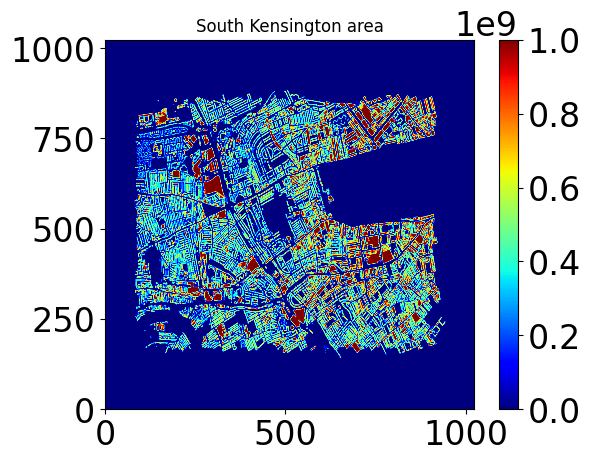

In [17]:
#################### Create field #####£###############
input_shape = (1,nz,ny,nx,1)
values_u = tf.zeros(input_shape)
values_v = tf.zeros(input_shape)
values_w = tf.zeros(input_shape)
values_p = tf.zeros(input_shape)
#######################################################
################# Numerical parameters ################
multi_itr = 4               # Iterations of multi-grid 
j_itr = 1                   # Iterations of Jacobi 
ntime = 4000                 # Time steps
n_out = 500                 # Results output
nrestart = 0                # Last time step for restart
ctime_old = 0               # Last ctime for restart
mgsolver = True             # Multigrid solver
LSCALAR = False              # Scalar transport 
LMTI = False                 # Non density for multiphase flows
LIBM = True                # Immersed boundary method 
nsafe = 0.5                 # Continuty equation residuals
ctime = 0                   # Initialise ctime   
save_fig = True             # Save results
Restart = True             # Restart
eplsion_k = 1e-03
################# Physical parameters #################
rho_l = 1000                # Density of liquid phase 
rho_g = 980                 # Density of gas phase 
g_x = 0;g_y = 0;g_z = -9.8   # Gravity acceleration (m/s2) 
#######################################################
print('============== Numerical parameters ===============')
print('Mesh resolution:', values_v.shape)
print('Time step:', ntime)
print('Initial time:', ctime)
#######################################################
################# Only for restart ####################
if Restart == True:
    temp1 = np.load('data_SK_Petrov_Galerkin_demo/uu8000.npy').astype('float32')
    temp2 = np.load('data_SK_Petrov_Galerkin_demo/vv8000.npy').astype('float32')
    temp3 = np.load('data_SK_Petrov_Galerkin_demo/ww8000.npy').astype('float32')
    temp4 = np.load('data_SK_Petrov_Galerkin_demo/pp8000.npy').astype('float32')
    values_u = tf.Variable(values_u)[0,:,:,:,0].assign(tf.convert_to_tensor(temp1))
    values_v = tf.Variable(values_v)[0,:,:,:,0].assign(tf.convert_to_tensor(temp2))
    values_w = tf.Variable(values_w)[0,:,:,:,0].assign(tf.convert_to_tensor(temp3))
    values_p = tf.Variable(values_p)[0,:,:,:,0].assign(tf.convert_to_tensor(temp4))
    nrestart = 8000
    ctime_old = nrestart*dt
    print('Restart solver!')
#######################################################    
################# Only for scalar #####################
if LSCALAR == True:
    alpha = np.zeros(input_shape).astype('float32')
    alpha[0,0:64,:,:,0] = 0
    alpha[0,64:128,:,:,0] = 1.0
    alpha = tf.convert_to_tensor(alpha)
    print('Switch on scalar filed solver!')
#######################################################
################# Only for scalar #####################
if LMTI == True:
    rho = tf.zeros(input_shape)
    rho = alpha*rho_l + (1-alpha)*rho_g
    print('Solving multiphase flows!')
else:
    rho = tf.ones(input_shape)
    print('Solving single-phase flows!')
################# Only for IBM ########################
if LIBM == True:
    mesh = np.load('INHALE_1280.npy')
    sigma = np.zeros(input_shape).astype('float32')
    for i in range(1,nx-1):
        for j in range(1,ny-1):
            for k in range(1,nz-1):
                if mesh[0][i+128][j+128][k][0] == 0:
                    sigma[0][k][j][i][0] = 1000000000  
    sigma = tf.convert_to_tensor(sigma)
    print('Switch on IBM solver!')
    print('===================================================')
    plt.imshow(sigma[0,1,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title('South Kensington area')
    plt.gca().invert_yaxis()
#######################################################

# AI-HFM Solver

In [18]:
start = time.time()
for itime in range(1,ntime+1): 
    ctime = ctime + dt 
    [values_u,values_v,values_w] = boundary_condition_velocity(values_u,values_v,values_w)
    values_p = boundary_condition_pressure(values_p,nx)
# Petrov-Galerkin dissipation
    [k_x,k_y,k_z] = Petrov_Galerkin_dissipation(values_u, values_v, values_w, eplsion_k, sigma)
# Momentum equation 
    a_u = k_x - \
    values_u*CNN3D_central_2nd_xadv(values_u) - \
    values_v*CNN3D_central_2nd_yadv(values_u) - \
    values_w*CNN3D_central_2nd_zadv(values_u)
    b_u = 0.5*a_u + values_u
    a_v = k_y - \
    values_u*CNN3D_central_2nd_xadv(values_v) - \
    values_v*CNN3D_central_2nd_yadv(values_v) - \
    values_w*CNN3D_central_2nd_zadv(values_v)
    b_v = 0.5*a_v + values_v
    a_w = k_z - \
    values_u*CNN3D_central_2nd_xadv(values_w) - \
    values_v*CNN3D_central_2nd_yadv(values_w) - \
    values_w*CNN3D_central_2nd_zadv(values_w) 
    b_w = 0.5*a_w + values_w

    [b_u,b_v,b_w] = boundary_condition_velocity(b_u,b_v,b_w)
    [kb_x,kb_y,kb_z] = Petrov_Galerkin_dissipation(b_u, b_v, b_w, eplsion_k, sigma)

    c_u = kb_x - \
    b_u*CNN3D_central_2nd_xadv(b_u) - \
    b_v*CNN3D_central_2nd_yadv(b_u) - \
    b_w*CNN3D_central_2nd_zadv(b_u)
    values_u = values_u + c_u      
    c_v = kb_y - \
    b_u*CNN3D_central_2nd_xadv(b_v) - \
    b_v*CNN3D_central_2nd_yadv(b_v) - \
    b_w*CNN3D_central_2nd_zadv(b_v) 
    values_v = values_v + c_v
    c_w = kb_z - \
    b_u*CNN3D_central_2nd_xadv(b_w) - \
    b_v*CNN3D_central_2nd_yadv(b_w) - \
    b_w*CNN3D_central_2nd_zadv(b_w) 
    values_w = values_w + c_w    
# Passive tracer scalar transport
    if LSCALAR == True:
        a_t = CNN3D_central_2nd_dif(alpha) - \
        values_u*CNN3D_central_2nd_xadv(alpha) - \
        values_v*CNN3D_central_2nd_yadv(alpha) - \
        values_w*CNN3D_central_2nd_zadv(alpha)
        alpha = alpha + a_t
        alpha = boundary_condition_indicator(alpha,nx)
    if LMTI == True:
        rho = alpha*rho_l + (1-alpha)*rho_g
# IBM
#     if LIBM == True:
    [values_u,values_v,values_w] = bluff_body(values_u,values_v,values_w,sigma)
# gradp            
    values_u = values_u - CNN3D_central_2nd_xadv(values_p)
    values_v = values_v - CNN3D_central_2nd_yadv(values_p)  
    values_w = values_w - CNN3D_central_2nd_zadv(values_p)     
    [values_u,values_v,values_w] = boundary_condition_velocity(values_u,values_v,values_w)
# possion equation (multi-grid) A*P = Su
    b = -(CNN3D_Su(values_u) + CNN3D_Sv(values_v) + CNN3D_Sw(values_w))
    b = boundary_condition_source(b,nx)
    if mgsolver == True:
        for multi_grid in range(multi_itr): 
            w_1 = tf.zeros([1,1,ratio,ratio,1])
            r = CNN3D_A_128(values_p) - b   
            r = tf.Variable(r)[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nz,ny)))[0,:]) 
#             r_256 = CNN3D_res_512(r) 
#             r_128 = CNN3D_res_256(r_256) 
            r_64 = CNN3D_res_128(r) 
            r_32 = CNN3D_res_64(r_64) 
            r_16 = CNN3D_res_32(r_32) 
            r_8 = CNN3D_res_16(r_16) 
            r_4 = CNN3D_res_8(r_8) 
            r_2 = CNN3D_res_4(r_4) 
            r_1 = CNN3D_res_2(r_2)
            for Jacobi in range(j_itr):
                w_1 = (w_1 - CNN3D_A_1(w_1)/w5[0,1,1,1,0] + r_1/w5[0,1,1,1,0])
            w_2 = CNN3D_prol_1(w_1)             
            for Jacobi in range(j_itr):
                w_2 = (w_2 - CNN3D_A_2(w_2)/w5[0,1,1,1,0] + r_2/w5[0,1,1,1,0])
            w_4 = CNN3D_prol_2(w_2) 
            for Jacobi in range(j_itr):
                w_4 = (w_4 - CNN3D_A_4(w_4)/w5[0,1,1,1,0] + r_4/w5[0,1,1,1,0])
            w_8 = CNN3D_prol_4(w_4) 
            for Jacobi in range(j_itr):
                w_8 = (w_8 - CNN3D_A_8(w_8)/w5[0,1,1,1,0] + r_8/w5[0,1,1,1,0])
            w_16 = CNN3D_prol_8(w_8) 
            for Jacobi in range(j_itr):
                w_16 = (w_16 - CNN3D_A_16(w_16)/w5[0,1,1,1,0] + r_16/w5[0,1,1,1,0])
            w_32 = CNN3D_prol_16(w_16) 
            for Jacobi in range(j_itr):
                w_32 = (w_32 - CNN3D_A_32(w_32)/w5[0,1,1,1,0] + r_32/w5[0,1,1,1,0])
            w_64 = CNN3D_prol_32(w_32) 
            for Jacobi in range(j_itr):
                w_64 = (w_64 - CNN3D_A_64(w_64)/w5[0,1,1,1,0] + r_64/w5[0,1,1,1,0])
            w_128 = CNN3D_prol_64(w_64) 
#             for Jacobi in range(j_itr):
#                 w_128 = (w_128 - CNN3D_A_128(w_128)/w5[0,1,1,1,0] + r_128/w5[0,1,1,1,0] )
#             w_256 = CNN3D_prol_128(w_128)
#             for Jacobi in range(j_itr):
#                 w_256 = (w_256 - CNN3D_A_256(w_256)/w5[0,1,1,1,0] + r_256/w5[0,1,1,1,0] )
#             w_512 = CNN3D_prol_256(w_256)
            values_p = values_p - w_128
            values_p = tf.Variable(values_p)[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nz,ny)))[0,:])         
            values_p = (values_p - CNN3D_A_128(values_p)/w5[0,1,1,1,0] + b/w5[0,1,1,1,0])          
# correct
    values_p = boundary_condition_pressure(values_p,nx)
    values_u = values_u - CNN3D_central_2nd_xadv(values_p)
    values_v = values_v - CNN3D_central_2nd_yadv(values_p)  
    values_w = values_w - CNN3D_central_2nd_zadv(values_p)      
    [values_u,values_v,values_w] = boundary_condition_velocity(values_u,values_v,values_w)
#     if LIBM == True:
    [values_u,values_v,values_w] = bluff_body(values_u,values_v,values_w,sigma)
# output   
    print('Time step:', itime) 
    print('Pressure error:', np.max(w_128), 'cty equation residual:', np.max(r))
    print('========================================================')
    if np.max(np.abs(w_128)) > nsafe:
        print('Not converged !!!!!!')
        break
    if save_fig == True:
        save_data(n_out,itime+nrestart)
end = time.time()
print('time',(end-start))

2022-11-04 18:30:37.702205: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-11-04 18:30:38.487085: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-04 18:30:38.487791: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-04 18:30:38.487803: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-11-04 18:30:38.488423: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-04 18:30:38.488465: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


Time step: 1
Pressure error: 0.0016357941 cty equation residual: 0.023293993
Time step: 2
Pressure error: 0.0016373687 cty equation residual: 0.023290733
Time step: 3
Pressure error: 0.0016385546 cty equation residual: 0.023286033
Time step: 4
Pressure error: 0.0016393553 cty equation residual: 0.02328
Time step: 5
Pressure error: 0.0016397753 cty equation residual: 0.023272658
Time step: 6
Pressure error: 0.0016398148 cty equation residual: 0.023264036
Time step: 7
Pressure error: 0.0016394655 cty equation residual: 0.023254216
Time step: 8
Pressure error: 0.0016387417 cty equation residual: 0.023243135
Time step: 9
Pressure error: 0.0016376324 cty equation residual: 0.02323109
Time step: 10
Pressure error: 0.0016361412 cty equation residual: 0.02321767
Time step: 11
Pressure error: 0.0016342725 cty equation residual: 0.02320289
Time step: 12
Pressure error: 0.0016320325 cty equation residual: 0.02318693
Time step: 13
Pressure error: 0.0016294239 cty equation residual: 0.023169747
Tim

Time step: 62
Pressure error: 0.0017951401 cty equation residual: 0.024405869
Time step: 63
Pressure error: 0.0018079501 cty equation residual: 0.024399117
Time step: 64
Pressure error: 0.0018205157 cty equation residual: 0.024384987
Time step: 65
Pressure error: 0.0018328225 cty equation residual: 0.02436338
Time step: 66
Pressure error: 0.0018448707 cty equation residual: 0.024334257
Time step: 67
Pressure error: 0.0018566357 cty equation residual: 0.024297811
Time step: 68
Pressure error: 0.0018681065 cty equation residual: 0.024254058
Time step: 69
Pressure error: 0.001879286 cty equation residual: 0.02420987
Time step: 70
Pressure error: 0.0018901408 cty equation residual: 0.024163518
Time step: 71
Pressure error: 0.0019006783 cty equation residual: 0.024111608
Time step: 72
Pressure error: 0.001910881 cty equation residual: 0.02405401
Time step: 73
Pressure error: 0.0019207489 cty equation residual: 0.023990823
Time step: 74
Pressure error: 0.0019302603 cty equation residual: 0.0

Time step: 123
Pressure error: 0.002023582 cty equation residual: 0.026928335
Time step: 124
Pressure error: 0.0020170002 cty equation residual: 0.026866343
Time step: 125
Pressure error: 0.0020102188 cty equation residual: 0.026795916
Time step: 126
Pressure error: 0.0020032376 cty equation residual: 0.026796225
Time step: 127
Pressure error: 0.0019960776 cty equation residual: 0.026835134
Time step: 128
Pressure error: 0.0019887371 cty equation residual: 0.026878173
Time step: 129
Pressure error: 0.0019812207 cty equation residual: 0.026912794
Time step: 130
Pressure error: 0.001973543 cty equation residual: 0.026937978
Time step: 131
Pressure error: 0.0019657132 cty equation residual: 0.026952576
Time step: 132
Pressure error: 0.001957746 cty equation residual: 0.02695609
Time step: 133
Pressure error: 0.0019496492 cty equation residual: 0.026948798
Time step: 134
Pressure error: 0.001941436 cty equation residual: 0.026930675
Time step: 135
Pressure error: 0.0019331004 cty equation 

Time step: 184
Pressure error: 0.0015162153 cty equation residual: 0.024157966
Time step: 185
Pressure error: 0.0015077821 cty equation residual: 0.024131635
Time step: 186
Pressure error: 0.0014992882 cty equation residual: 0.02410251
Time step: 187
Pressure error: 0.0014907361 cty equation residual: 0.024070507
Time step: 188
Pressure error: 0.0014821378 cty equation residual: 0.024035618
Time step: 189
Pressure error: 0.0014734718 cty equation residual: 0.023998095
Time step: 190
Pressure error: 0.0014647465 cty equation residual: 0.023999639
Time step: 191
Pressure error: 0.0014559578 cty equation residual: 0.024008421
Time step: 192
Pressure error: 0.0014471052 cty equation residual: 0.024012804
Time step: 193
Pressure error: 0.0014382155 cty equation residual: 0.02401297
Time step: 194
Pressure error: 0.0014292719 cty equation residual: 0.024009023
Time step: 195
Pressure error: 0.0014202684 cty equation residual: 0.024052221
Time step: 196
Pressure error: 0.001411198 cty equatio

Time step: 245
Pressure error: 0.0010437958 cty equation residual: 0.024488037
Time step: 246
Pressure error: 0.0010376398 cty equation residual: 0.024519885
Time step: 247
Pressure error: 0.0010316491 cty equation residual: 0.024653992
Time step: 248
Pressure error: 0.0010258291 cty equation residual: 0.024783809
Time step: 249
Pressure error: 0.0010201851 cty equation residual: 0.024908366
Time step: 250
Pressure error: 0.001014706 cty equation residual: 0.025026808
Time step: 251
Pressure error: 0.0010093898 cty equation residual: 0.02513923
Time step: 252
Pressure error: 0.0010042482 cty equation residual: 0.025244871
Time step: 253
Pressure error: 0.0009992622 cty equation residual: 0.02534407
Time step: 254
Pressure error: 0.0009944481 cty equation residual: 0.025439292
Time step: 255
Pressure error: 0.0010005214 cty equation residual: 0.025527567
Time step: 256
Pressure error: 0.0010083175 cty equation residual: 0.025608266
Time step: 257
Pressure error: 0.0010156172 cty equatio

Time step: 306
Pressure error: 0.0010092948 cty equation residual: 0.024763789
Time step: 307
Pressure error: 0.0010226796 cty equation residual: 0.024695963
Time step: 308
Pressure error: 0.0010356081 cty equation residual: 0.024629135
Time step: 309
Pressure error: 0.0010480878 cty equation residual: 0.024564452
Time step: 310
Pressure error: 0.0010601208 cty equation residual: 0.024507893
Time step: 311
Pressure error: 0.0010716991 cty equation residual: 0.024472918
Time step: 312
Pressure error: 0.001082817 cty equation residual: 0.024457175
Time step: 313
Pressure error: 0.0010934812 cty equation residual: 0.0244711
Time step: 314
Pressure error: 0.0011036843 cty equation residual: 0.024478596
Time step: 315
Pressure error: 0.001113469 cty equation residual: 0.024479628
Time step: 316
Pressure error: 0.0011228429 cty equation residual: 0.024474649
Time step: 317
Pressure error: 0.0011317815 cty equation residual: 0.024464026
Time step: 318
Pressure error: 0.0011402924 cty equation

Time step: 367
Pressure error: 0.0021991448 cty equation residual: 0.027755974
Time step: 368
Pressure error: 0.0022222912 cty equation residual: 0.027807407
Time step: 369
Pressure error: 0.002244206 cty equation residual: 0.02784197
Time step: 370
Pressure error: 0.0022648694 cty equation residual: 0.027866151
Time step: 371
Pressure error: 0.0022842332 cty equation residual: 0.027872002
Time step: 372
Pressure error: 0.0023022522 cty equation residual: 0.027862733
Time step: 373
Pressure error: 0.0023188768 cty equation residual: 0.027845463
Time step: 374
Pressure error: 0.0023340818 cty equation residual: 0.027810156
Time step: 375
Pressure error: 0.0023478367 cty equation residual: 0.027756816
Time step: 376
Pressure error: 0.0023601076 cty equation residual: 0.027693808
Time step: 377
Pressure error: 0.0023708637 cty equation residual: 0.02761913
Time step: 378
Pressure error: 0.0023800815 cty equation residual: 0.027540954
Time step: 379
Pressure error: 0.0023876748 cty equatio

Time step: 428
Pressure error: 0.0025091232 cty equation residual: 0.023709185
Time step: 429
Pressure error: 0.0025025634 cty equation residual: 0.023748929
Time step: 430
Pressure error: 0.0024957901 cty equation residual: 0.023804333
Time step: 431
Pressure error: 0.0024888464 cty equation residual: 0.023866061
Time step: 432
Pressure error: 0.002481787 cty equation residual: 0.023929384
Time step: 433
Pressure error: 0.002474625 cty equation residual: 0.023994045
Time step: 434
Pressure error: 0.002467358 cty equation residual: 0.024059894
Time step: 435
Pressure error: 0.0024599857 cty equation residual: 0.024129378
Time step: 436
Pressure error: 0.002452555 cty equation residual: 0.02420085
Time step: 437
Pressure error: 0.0024450836 cty equation residual: 0.024272956
Time step: 438
Pressure error: 0.0024376023 cty equation residual: 0.024345305
Time step: 439
Pressure error: 0.0024301137 cty equation residual: 0.024417425
Time step: 440
Pressure error: 0.0024226378 cty equation 

Time step: 489
Pressure error: 0.002166541 cty equation residual: 0.023900928
Time step: 490
Pressure error: 0.0021621725 cty equation residual: 0.023865141
Time step: 491
Pressure error: 0.0021577303 cty equation residual: 0.023837592
Time step: 492
Pressure error: 0.0021531878 cty equation residual: 0.023835767
Time step: 493
Pressure error: 0.0021485696 cty equation residual: 0.023830518
Time step: 494
Pressure error: 0.002143855 cty equation residual: 0.02382559
Time step: 495
Pressure error: 0.0021390447 cty equation residual: 0.023840332
Time step: 496
Pressure error: 0.0021341275 cty equation residual: 0.023856362
Time step: 497
Pressure error: 0.002129099 cty equation residual: 0.023872623
Time step: 498
Pressure error: 0.00212395 cty equation residual: 0.023887806
Time step: 499
Pressure error: 0.0021186764 cty equation residual: 0.023901
Time step: 500
Pressure error: 0.0021132645 cty equation residual: 0.023911452
Time step: 501
Pressure error: 0.002107722 cty equation resid

Time step: 550
Pressure error: 0.0017380754 cty equation residual: 0.024598317
Time step: 551
Pressure error: 0.0017326599 cty equation residual: 0.02462181
Time step: 552
Pressure error: 0.0017272683 cty equation residual: 0.024641652
Time step: 553
Pressure error: 0.0017218937 cty equation residual: 0.024664894
Time step: 554
Pressure error: 0.0017165375 cty equation residual: 0.024690576
Time step: 555
Pressure error: 0.0017111854 cty equation residual: 0.024712281
Time step: 556
Pressure error: 0.0017058536 cty equation residual: 0.024728982
Time step: 557
Pressure error: 0.0017005214 cty equation residual: 0.024739826
Time step: 558
Pressure error: 0.0016951963 cty equation residual: 0.024744172
Time step: 559
Pressure error: 0.0016898517 cty equation residual: 0.024751296
Time step: 560
Pressure error: 0.0016845014 cty equation residual: 0.024755329
Time step: 561
Pressure error: 0.0016791262 cty equation residual: 0.024752859
Time step: 562
Pressure error: 0.0016737266 cty equat

Time step: 611
Pressure error: 0.001653423 cty equation residual: 0.024604058
Time step: 612
Pressure error: 0.0016724492 cty equation residual: 0.024634188
Time step: 613
Pressure error: 0.0016906848 cty equation residual: 0.02466361
Time step: 614
Pressure error: 0.0017081363 cty equation residual: 0.024693813
Time step: 615
Pressure error: 0.0017247703 cty equation residual: 0.02472963
Time step: 616
Pressure error: 0.0017405372 cty equation residual: 0.024764601
Time step: 617
Pressure error: 0.0017554419 cty equation residual: 0.024798887
Time step: 618
Pressure error: 0.0017694471 cty equation residual: 0.024830993
Time step: 619
Pressure error: 0.0017825072 cty equation residual: 0.02485748
Time step: 620
Pressure error: 0.0017946393 cty equation residual: 0.024878021
Time step: 621
Pressure error: 0.001805838 cty equation residual: 0.02489299
Time step: 622
Pressure error: 0.0018161502 cty equation residual: 0.024902396
Time step: 623
Pressure error: 0.0018320153 cty equation r

Time step: 672
Pressure error: 0.0017059974 cty equation residual: 0.024923012
Time step: 673
Pressure error: 0.001694788 cty equation residual: 0.024904938
Time step: 674
Pressure error: 0.0016837023 cty equation residual: 0.024880983
Time step: 675
Pressure error: 0.0016880938 cty equation residual: 0.02485102
Time step: 676
Pressure error: 0.0017011263 cty equation residual: 0.024815446
Time step: 677
Pressure error: 0.001713713 cty equation residual: 0.024774976
Time step: 678
Pressure error: 0.0017258575 cty equation residual: 0.024744533
Time step: 679
Pressure error: 0.0017375499 cty equation residual: 0.02471204
Time step: 680
Pressure error: 0.0017487733 cty equation residual: 0.024675034
Time step: 681
Pressure error: 0.0017595356 cty equation residual: 0.024633618
Time step: 682
Pressure error: 0.0017698278 cty equation residual: 0.02458786
Time step: 683
Pressure error: 0.00177966 cty equation residual: 0.02453867
Time step: 684
Pressure error: 0.0017890312 cty equation res

Time step: 733
Pressure error: 0.0018083911 cty equation residual: 0.0249811
Time step: 734
Pressure error: 0.0018028964 cty equation residual: 0.024918985
Time step: 735
Pressure error: 0.0017972377 cty equation residual: 0.024848958
Time step: 736
Pressure error: 0.0017914217 cty equation residual: 0.02477144
Time step: 737
Pressure error: 0.0017854354 cty equation residual: 0.024686918
Time step: 738
Pressure error: 0.0017792875 cty equation residual: 0.024595832
Time step: 739
Pressure error: 0.0017729669 cty equation residual: 0.02449875
Time step: 740
Pressure error: 0.0017664728 cty equation residual: 0.02439647
Time step: 741
Pressure error: 0.0017597771 cty equation residual: 0.024302341
Time step: 742
Pressure error: 0.0017528856 cty equation residual: 0.024222165
Time step: 743
Pressure error: 0.001745806 cty equation residual: 0.024223374
Time step: 744
Pressure error: 0.0017385199 cty equation residual: 0.02432153
Time step: 745
Pressure error: 0.0017310311 cty equation re

Time step: 794
Pressure error: 0.0019915143 cty equation residual: 0.024965826
Time step: 795
Pressure error: 0.0020016169 cty equation residual: 0.02494495
Time step: 796
Pressure error: 0.002011546 cty equation residual: 0.02491766
Time step: 797
Pressure error: 0.0020213102 cty equation residual: 0.024883399
Time step: 798
Pressure error: 0.0020308995 cty equation residual: 0.024841895
Time step: 799
Pressure error: 0.002040308 cty equation residual: 0.024795122
Time step: 800
Pressure error: 0.0020495239 cty equation residual: 0.024851097
Time step: 801
Pressure error: 0.0020585458 cty equation residual: 0.024922544
Time step: 802
Pressure error: 0.0020673655 cty equation residual: 0.024993857
Time step: 803
Pressure error: 0.0020759683 cty equation residual: 0.025065053
Time step: 804
Pressure error: 0.0020843467 cty equation residual: 0.025133789
Time step: 805
Pressure error: 0.0020924797 cty equation residual: 0.025199836
Time step: 806
Pressure error: 0.0021003545 cty equation

Time step: 855
Pressure error: 0.0021442699 cty equation residual: 0.026005846
Time step: 856
Pressure error: 0.0021509752 cty equation residual: 0.026055995
Time step: 857
Pressure error: 0.0021579133 cty equation residual: 0.02612479
Time step: 858
Pressure error: 0.002165072 cty equation residual: 0.02619002
Time step: 859
Pressure error: 0.0021724594 cty equation residual: 0.026251111
Time step: 860
Pressure error: 0.0021800776 cty equation residual: 0.026307512
Time step: 861
Pressure error: 0.002187911 cty equation residual: 0.026361478
Time step: 862
Pressure error: 0.002195952 cty equation residual: 0.026430141
Time step: 863
Pressure error: 0.0022041937 cty equation residual: 0.026492622
Time step: 864
Pressure error: 0.0022126313 cty equation residual: 0.026548147
Time step: 865
Pressure error: 0.0022212444 cty equation residual: 0.026595658
Time step: 866
Pressure error: 0.0022300323 cty equation residual: 0.026654571
Time step: 867
Pressure error: 0.0022389714 cty equation 

Time step: 916
Pressure error: 0.0025859985 cty equation residual: 0.025699193
Time step: 917
Pressure error: 0.0025890185 cty equation residual: 0.025700886
Time step: 918
Pressure error: 0.0025919795 cty equation residual: 0.02570618
Time step: 919
Pressure error: 0.002594915 cty equation residual: 0.025725357
Time step: 920
Pressure error: 0.0025977923 cty equation residual: 0.02573822
Time step: 921
Pressure error: 0.0026005825 cty equation residual: 0.025744598
Time step: 922
Pressure error: 0.0026032971 cty equation residual: 0.025744442
Time step: 923
Pressure error: 0.0026059544 cty equation residual: 0.025737723
Time step: 924
Pressure error: 0.0026085554 cty equation residual: 0.02572453
Time step: 925
Pressure error: 0.0026110627 cty equation residual: 0.025704898
Time step: 926
Pressure error: 0.0026134967 cty equation residual: 0.025679167
Time step: 927
Pressure error: 0.0026201915 cty equation residual: 0.025660554
Time step: 928
Pressure error: 0.0026294307 cty equation

Time step: 977
Pressure error: 0.002915807 cty equation residual: 0.025722288
Time step: 978
Pressure error: 0.002915859 cty equation residual: 0.025781348
Time step: 979
Pressure error: 0.0029156173 cty equation residual: 0.025832418
Time step: 980
Pressure error: 0.0029150918 cty equation residual: 0.025886973
Time step: 981
Pressure error: 0.0029142885 cty equation residual: 0.025939554
Time step: 982
Pressure error: 0.0029132054 cty equation residual: 0.025983304
Time step: 983
Pressure error: 0.0029118324 cty equation residual: 0.026033599
Time step: 984
Pressure error: 0.0029101819 cty equation residual: 0.026073586
Time step: 985
Pressure error: 0.00290825 cty equation residual: 0.026103066
Time step: 986
Pressure error: 0.0029060359 cty equation residual: 0.026121201
Time step: 987
Pressure error: 0.0029035155 cty equation residual: 0.026127443
Time step: 988
Pressure error: 0.0029006752 cty equation residual: 0.026120156
Time step: 989
Pressure error: 0.0028975299 cty equation

Time step: 1038
Pressure error: 0.0025996794 cty equation residual: 0.027116477
Time step: 1039
Pressure error: 0.0025944258 cty equation residual: 0.027154583
Time step: 1040
Pressure error: 0.0025892304 cty equation residual: 0.027236264
Time step: 1041
Pressure error: 0.0025840576 cty equation residual: 0.027336957
Time step: 1042
Pressure error: 0.0025788916 cty equation residual: 0.02743475
Time step: 1043
Pressure error: 0.0025737407 cty equation residual: 0.027521087
Time step: 1044
Pressure error: 0.0025686002 cty equation residual: 0.027594874
Time step: 1045
Pressure error: 0.0025634698 cty equation residual: 0.027655859
Time step: 1046
Pressure error: 0.002558367 cty equation residual: 0.02771026
Time step: 1047
Pressure error: 0.0025537848 cty equation residual: 0.027748052
Time step: 1048
Pressure error: 0.0025535596 cty equation residual: 0.027766384
Time step: 1049
Pressure error: 0.0025533985 cty equation residual: 0.02776656
Time step: 1050
Pressure error: 0.0025532865

Time step: 1098
Pressure error: 0.0024626039 cty equation residual: 0.02594585
Time step: 1099
Pressure error: 0.0024630732 cty equation residual: 0.02592484
Time step: 1100
Pressure error: 0.002463305 cty equation residual: 0.025897592
Time step: 1101
Pressure error: 0.0024632784 cty equation residual: 0.025864903
Time step: 1102
Pressure error: 0.0024630057 cty equation residual: 0.025827091
Time step: 1103
Pressure error: 0.002462471 cty equation residual: 0.025785085
Time step: 1104
Pressure error: 0.0024616616 cty equation residual: 0.025739532
Time step: 1105
Pressure error: 0.0024605757 cty equation residual: 0.02569088
Time step: 1106
Pressure error: 0.0024592187 cty equation residual: 0.025639586
Time step: 1107
Pressure error: 0.0024575824 cty equation residual: 0.025586652
Time step: 1108
Pressure error: 0.0024556655 cty equation residual: 0.025532866
Time step: 1109
Pressure error: 0.0024534604 cty equation residual: 0.025478868
Time step: 1110
Pressure error: 0.002450953 c

Time step: 1158
Pressure error: 0.00242911 cty equation residual: 0.026673708
Time step: 1159
Pressure error: 0.0024234215 cty equation residual: 0.026742665
Time step: 1160
Pressure error: 0.0024174168 cty equation residual: 0.026807219
Time step: 1161
Pressure error: 0.0024110961 cty equation residual: 0.026866376
Time step: 1162
Pressure error: 0.0024044812 cty equation residual: 0.026919005
Time step: 1163
Pressure error: 0.0023975875 cty equation residual: 0.026964337
Time step: 1164
Pressure error: 0.0023904168 cty equation residual: 0.027002579
Time step: 1165
Pressure error: 0.0023829797 cty equation residual: 0.027037473
Time step: 1166
Pressure error: 0.002375287 cty equation residual: 0.027085349
Time step: 1167
Pressure error: 0.0023673417 cty equation residual: 0.027148576
Time step: 1168
Pressure error: 0.0023591632 cty equation residual: 0.027207587
Time step: 1169
Pressure error: 0.002350761 cty equation residual: 0.027262151
Time step: 1170
Pressure error: 0.0023421508

Time step: 1218
Pressure error: 0.0021214902 cty equation residual: 0.026690254
Time step: 1219
Pressure error: 0.0021344335 cty equation residual: 0.026704395
Time step: 1220
Pressure error: 0.00214654 cty equation residual: 0.026707232
Time step: 1221
Pressure error: 0.002157796 cty equation residual: 0.02669911
Time step: 1222
Pressure error: 0.0021682093 cty equation residual: 0.026681075
Time step: 1223
Pressure error: 0.0021777432 cty equation residual: 0.026653932
Time step: 1224
Pressure error: 0.0021864164 cty equation residual: 0.026618408
Time step: 1225
Pressure error: 0.0021942144 cty equation residual: 0.026575154
Time step: 1226
Pressure error: 0.0022011274 cty equation residual: 0.026524894
Time step: 1227
Pressure error: 0.002207147 cty equation residual: 0.026468452
Time step: 1228
Pressure error: 0.0022122848 cty equation residual: 0.026406322
Time step: 1229
Pressure error: 0.0022165354 cty equation residual: 0.026338546
Time step: 1230
Pressure error: 0.002219907 c

Pressure error: 0.00234818 cty equation residual: 0.027093846
Time step: 1279
Pressure error: 0.0023536417 cty equation residual: 0.02712719
Time step: 1280
Pressure error: 0.00235887 cty equation residual: 0.027152488
Time step: 1281
Pressure error: 0.0023638671 cty equation residual: 0.027169699
Time step: 1282
Pressure error: 0.0023686239 cty equation residual: 0.027179288
Time step: 1283
Pressure error: 0.002374127 cty equation residual: 0.027183194
Time step: 1284
Pressure error: 0.002387087 cty equation residual: 0.027180975
Time step: 1285
Pressure error: 0.0023997661 cty equation residual: 0.027189832
Time step: 1286
Pressure error: 0.002412137 cty equation residual: 0.027197544
Time step: 1287
Pressure error: 0.0024241817 cty equation residual: 0.027197216
Time step: 1288
Pressure error: 0.0024358986 cty equation residual: 0.0271869
Time step: 1289
Pressure error: 0.0024473073 cty equation residual: 0.02716665
Time step: 1290
Pressure error: 0.0024583905 cty equation residual:

Time step: 1339
Pressure error: 0.0027218573 cty equation residual: 0.025539387
Time step: 1340
Pressure error: 0.002722053 cty equation residual: 0.025534801
Time step: 1341
Pressure error: 0.0027218896 cty equation residual: 0.02552623
Time step: 1342
Pressure error: 0.0027213772 cty equation residual: 0.025512978
Time step: 1343
Pressure error: 0.0027205262 cty equation residual: 0.025494486
Time step: 1344
Pressure error: 0.0027193292 cty equation residual: 0.025470478
Time step: 1345
Pressure error: 0.0027177918 cty equation residual: 0.025440285
Time step: 1346
Pressure error: 0.0027159383 cty equation residual: 0.025412455
Time step: 1347
Pressure error: 0.0027137608 cty equation residual: 0.02544893
Time step: 1348
Pressure error: 0.0027112737 cty equation residual: 0.025482731
Time step: 1349
Pressure error: 0.0027084954 cty equation residual: 0.025516469
Time step: 1350
Pressure error: 0.0027054274 cty equation residual: 0.025554627
Time step: 1351
Pressure error: 0.002702091

Time step: 1399
Pressure error: 0.0023702118 cty equation residual: 0.026143495
Time step: 1400
Pressure error: 0.002362673 cty equation residual: 0.026166007
Time step: 1401
Pressure error: 0.0023552063 cty equation residual: 0.026184663
Time step: 1402
Pressure error: 0.0023478207 cty equation residual: 0.02619933
Time step: 1403
Pressure error: 0.0023405124 cty equation residual: 0.026209775
Time step: 1404
Pressure error: 0.0023332895 cty equation residual: 0.026215922
Time step: 1405
Pressure error: 0.0023261372 cty equation residual: 0.0262177
Time step: 1406
Pressure error: 0.0023190617 cty equation residual: 0.026215121
Time step: 1407
Pressure error: 0.0023120595 cty equation residual: 0.026208133
Time step: 1408
Pressure error: 0.0023051365 cty equation residual: 0.026196731
Time step: 1409
Pressure error: 0.002298303 cty equation residual: 0.026181046
Time step: 1410
Pressure error: 0.0022915755 cty equation residual: 0.026181255
Time step: 1411
Pressure error: 0.0022849292 

Time step: 1459
Pressure error: 0.002073908 cty equation residual: 0.025501322
Time step: 1460
Pressure error: 0.0020691822 cty equation residual: 0.025507107
Time step: 1461
Pressure error: 0.0020644024 cty equation residual: 0.025591742
Time step: 1462
Pressure error: 0.002059568 cty equation residual: 0.025669102
Time step: 1463
Pressure error: 0.0020546895 cty equation residual: 0.025738847
Time step: 1464
Pressure error: 0.0020497637 cty equation residual: 0.025801089
Time step: 1465
Pressure error: 0.0020448016 cty equation residual: 0.025855757
Time step: 1466
Pressure error: 0.0020401531 cty equation residual: 0.025922772
Time step: 1467
Pressure error: 0.0020362195 cty equation residual: 0.025982555
Time step: 1468
Pressure error: 0.0020322115 cty equation residual: 0.026033454
Time step: 1469
Pressure error: 0.002028101 cty equation residual: 0.026075542
Time step: 1470
Pressure error: 0.0020238967 cty equation residual: 0.026109077
Time step: 1471
Pressure error: 0.002019579

Time step: 1519
Pressure error: 0.0017624361 cty equation residual: 0.02621445
Time step: 1520
Pressure error: 0.0017583653 cty equation residual: 0.026200417
Time step: 1521
Pressure error: 0.0017544122 cty equation residual: 0.026175708
Time step: 1522
Pressure error: 0.0017505815 cty equation residual: 0.026139053
Time step: 1523
Pressure error: 0.0017468714 cty equation residual: 0.026088836
Time step: 1524
Pressure error: 0.0017432906 cty equation residual: 0.026024597
Time step: 1525
Pressure error: 0.0017432553 cty equation residual: 0.025946638
Time step: 1526
Pressure error: 0.0017481137 cty equation residual: 0.025860047
Time step: 1527
Pressure error: 0.001752923 cty equation residual: 0.02577386
Time step: 1528
Pressure error: 0.0017576922 cty equation residual: 0.02569871
Time step: 1529
Pressure error: 0.0017624072 cty equation residual: 0.025612373
Time step: 1530
Pressure error: 0.0017670864 cty equation residual: 0.025539715
Time step: 1531
Pressure error: 0.0017717138

Time step: 1579
Pressure error: 0.0020471388 cty equation residual: 0.02553071
Time step: 1580
Pressure error: 0.0020502051 cty equation residual: 0.02551431
Time step: 1581
Pressure error: 0.0020531237 cty equation residual: 0.025496837
Time step: 1582
Pressure error: 0.002055896 cty equation residual: 0.025481857
Time step: 1583
Pressure error: 0.0020585137 cty equation residual: 0.025466807
Time step: 1584
Pressure error: 0.0020609908 cty equation residual: 0.025450028
Time step: 1585
Pressure error: 0.0020633065 cty equation residual: 0.025431518
Time step: 1586
Pressure error: 0.0020654695 cty equation residual: 0.025411379
Time step: 1587
Pressure error: 0.0020691124 cty equation residual: 0.02539275
Time step: 1588
Pressure error: 0.0020751127 cty equation residual: 0.025376331
Time step: 1589
Pressure error: 0.0020809567 cty equation residual: 0.025359696
Time step: 1590
Pressure error: 0.0020866366 cty equation residual: 0.02534299
Time step: 1591
Pressure error: 0.0020921605 

Time step: 1639
Pressure error: 0.0020722998 cty equation residual: 0.025037106
Time step: 1640
Pressure error: 0.0020719157 cty equation residual: 0.025007011
Time step: 1641
Pressure error: 0.0020739338 cty equation residual: 0.02497154
Time step: 1642
Pressure error: 0.0020757355 cty equation residual: 0.024927206
Time step: 1643
Pressure error: 0.0020773148 cty equation residual: 0.02489033
Time step: 1644
Pressure error: 0.0020786645 cty equation residual: 0.024867825
Time step: 1645
Pressure error: 0.0020797823 cty equation residual: 0.024844008
Time step: 1646
Pressure error: 0.0020806736 cty equation residual: 0.024913084
Time step: 1647
Pressure error: 0.0020813134 cty equation residual: 0.024983704
Time step: 1648
Pressure error: 0.002081709 cty equation residual: 0.025045348
Time step: 1649
Pressure error: 0.0020818436 cty equation residual: 0.025093956
Time step: 1650
Pressure error: 0.0020817127 cty equation residual: 0.025129825
Time step: 1651
Pressure error: 0.002081290

Time step: 1699
Pressure error: 0.0018189372 cty equation residual: 0.024936546
Time step: 1700
Pressure error: 0.0018129642 cty equation residual: 0.024877543
Time step: 1701
Pressure error: 0.0018067952 cty equation residual: 0.024817407
Time step: 1702
Pressure error: 0.0018004292 cty equation residual: 0.024755761
Time step: 1703
Pressure error: 0.0017938714 cty equation residual: 0.024692938
Time step: 1704
Pressure error: 0.0017871005 cty equation residual: 0.02462921
Time step: 1705
Pressure error: 0.0017801222 cty equation residual: 0.024598744
Time step: 1706
Pressure error: 0.0017729054 cty equation residual: 0.024573635
Time step: 1707
Pressure error: 0.0017654307 cty equation residual: 0.024545962
Time step: 1708
Pressure error: 0.0017577029 cty equation residual: 0.02451586
Time step: 1709
Pressure error: 0.0017496964 cty equation residual: 0.024483506
Time step: 1710
Pressure error: 0.0017414162 cty equation residual: 0.024463132
Time step: 1711
Pressure error: 0.00173285

Time step: 1759
Pressure error: 0.0014536722 cty equation residual: 0.025040463
Time step: 1760
Pressure error: 0.0014684933 cty equation residual: 0.025049154
Time step: 1761
Pressure error: 0.0014831469 cty equation residual: 0.025053777
Time step: 1762
Pressure error: 0.0014976319 cty equation residual: 0.025066657
Time step: 1763
Pressure error: 0.0015119191 cty equation residual: 0.02507877
Time step: 1764
Pressure error: 0.0015260277 cty equation residual: 0.025086923
Time step: 1765
Pressure error: 0.0015399439 cty equation residual: 0.025090845
Time step: 1766
Pressure error: 0.0015536611 cty equation residual: 0.025090294
Time step: 1767
Pressure error: 0.0015671665 cty equation residual: 0.025084984
Time step: 1768
Pressure error: 0.0015804747 cty equation residual: 0.025074787
Time step: 1769
Pressure error: 0.001593565 cty equation residual: 0.025062922
Time step: 1770
Pressure error: 0.0016064332 cty equation residual: 0.025054045
Time step: 1771
Pressure error: 0.00161908

Time step: 1819
Pressure error: 0.0020451536 cty equation residual: 0.025018647
Time step: 1820
Pressure error: 0.0020505623 cty equation residual: 0.025030727
Time step: 1821
Pressure error: 0.002055743 cty equation residual: 0.025034213
Time step: 1822
Pressure error: 0.0020606888 cty equation residual: 0.025052523
Time step: 1823
Pressure error: 0.0020653799 cty equation residual: 0.02511579
Time step: 1824
Pressure error: 0.0020697936 cty equation residual: 0.025176277
Time step: 1825
Pressure error: 0.0020738975 cty equation residual: 0.025246806
Time step: 1826
Pressure error: 0.0020776938 cty equation residual: 0.025315665
Time step: 1827
Pressure error: 0.0020811718 cty equation residual: 0.025380509
Time step: 1828
Pressure error: 0.0020843274 cty equation residual: 0.025440456
Time step: 1829
Pressure error: 0.0020871635 cty equation residual: 0.025495084
Time step: 1830
Pressure error: 0.0020896546 cty equation residual: 0.025543727
Time step: 1831
Pressure error: 0.00209181

Pressure error: 0.0018748668 cty equation residual: 0.025707621
Time step: 1880
Pressure error: 0.0018677828 cty equation residual: 0.02568563
Time step: 1881
Pressure error: 0.0018608045 cty equation residual: 0.025652174
Time step: 1882
Pressure error: 0.0018539504 cty equation residual: 0.025608754
Time step: 1883
Pressure error: 0.001847235 cty equation residual: 0.025554508
Time step: 1884
Pressure error: 0.001840652 cty equation residual: 0.025489196
Time step: 1885
Pressure error: 0.0018342282 cty equation residual: 0.02541292
Time step: 1886
Pressure error: 0.0018279513 cty equation residual: 0.02532648
Time step: 1887
Pressure error: 0.0018218205 cty equation residual: 0.02523018
Time step: 1888
Pressure error: 0.0018158184 cty equation residual: 0.025127307
Time step: 1889
Pressure error: 0.0018099598 cty equation residual: 0.025034709
Time step: 1890
Pressure error: 0.001804243 cty equation residual: 0.024932837
Time step: 1891
Pressure error: 0.0017986861 cty equation resid

Pressure error: 0.0017342912 cty equation residual: 0.026535507
Time step: 1940
Pressure error: 0.0017378476 cty equation residual: 0.026565671
Time step: 1941
Pressure error: 0.0017407537 cty equation residual: 0.026587857
Time step: 1942
Pressure error: 0.001743018 cty equation residual: 0.026601985
Time step: 1943
Pressure error: 0.0017446398 cty equation residual: 0.02660818
Time step: 1944
Pressure error: 0.0017456259 cty equation residual: 0.026606392
Time step: 1945
Pressure error: 0.0017459935 cty equation residual: 0.026596937
Time step: 1946
Pressure error: 0.0017457429 cty equation residual: 0.026579808
Time step: 1947
Pressure error: 0.0017448834 cty equation residual: 0.02655518
Time step: 1948
Pressure error: 0.001743428 cty equation residual: 0.02652308
Time step: 1949
Pressure error: 0.0017413832 cty equation residual: 0.026483793
Time step: 1950
Pressure error: 0.001738759 cty equation residual: 0.02643757
Time step: 1951
Pressure error: 0.0017355699 cty equation resid

Time step: 2000
Pressure error: 0.0023220137 cty equation residual: 0.025411412
Time step: 2001
Pressure error: 0.0023338213 cty equation residual: 0.025440637
Time step: 2002
Pressure error: 0.002345196 cty equation residual: 0.025490083
Time step: 2003
Pressure error: 0.002356134 cty equation residual: 0.025539584
Time step: 2004
Pressure error: 0.0023665973 cty equation residual: 0.025582206
Time step: 2005
Pressure error: 0.0023765732 cty equation residual: 0.025618061
Time step: 2006
Pressure error: 0.0023862026 cty equation residual: 0.025647152
Time step: 2007
Pressure error: 0.0024062365 cty equation residual: 0.02567343
Time step: 2008
Pressure error: 0.002425533 cty equation residual: 0.025712103
Time step: 2009
Pressure error: 0.0024440424 cty equation residual: 0.025768396
Time step: 2010
Pressure error: 0.0024617566 cty equation residual: 0.025814164
Time step: 2011
Pressure error: 0.002478621 cty equation residual: 0.0258495
Time step: 2012
Pressure error: 0.0024946374 ct

Time step: 2060
Pressure error: 0.0024661731 cty equation residual: 0.0271153
Time step: 2061
Pressure error: 0.0024500242 cty equation residual: 0.027140671
Time step: 2062
Pressure error: 0.0024327815 cty equation residual: 0.02716406
Time step: 2063
Pressure error: 0.0024144468 cty equation residual: 0.027184315
Time step: 2064
Pressure error: 0.002395023 cty equation residual: 0.027192906
Time step: 2065
Pressure error: 0.0023745561 cty equation residual: 0.027189042
Time step: 2066
Pressure error: 0.002353167 cty equation residual: 0.027174763
Time step: 2067
Pressure error: 0.0023392513 cty equation residual: 0.027150514
Time step: 2068
Pressure error: 0.002323808 cty equation residual: 0.027117701
Time step: 2069
Pressure error: 0.0023068243 cty equation residual: 0.027078388
Time step: 2070
Pressure error: 0.0022883068 cty equation residual: 0.027031114
Time step: 2071
Pressure error: 0.0022682548 cty equation residual: 0.02697574
Time step: 2072
Pressure error: 0.0022467077 ct

Time step: 2120
Pressure error: 0.0019484458 cty equation residual: 0.024882324
Time step: 2121
Pressure error: 0.0019589136 cty equation residual: 0.02489361
Time step: 2122
Pressure error: 0.001969045 cty equation residual: 0.024898682
Time step: 2123
Pressure error: 0.0019788295 cty equation residual: 0.024900459
Time step: 2124
Pressure error: 0.0019882405 cty equation residual: 0.02489503
Time step: 2125
Pressure error: 0.0019972734 cty equation residual: 0.024882086
Time step: 2126
Pressure error: 0.0020058956 cty equation residual: 0.024883099
Time step: 2127
Pressure error: 0.0020141013 cty equation residual: 0.024918998
Time step: 2128
Pressure error: 0.002021865 cty equation residual: 0.02495521
Time step: 2129
Pressure error: 0.0020291777 cty equation residual: 0.024991551
Time step: 2130
Pressure error: 0.002036022 cty equation residual: 0.025027955
Time step: 2131
Pressure error: 0.0020423862 cty equation residual: 0.025064219
Time step: 2132
Pressure error: 0.0020482556 c

Pressure error: 0.0018751913 cty equation residual: 0.026218332
Time step: 2181
Pressure error: 0.0018679457 cty equation residual: 0.026291303
Time step: 2182
Pressure error: 0.0018608258 cty equation residual: 0.026374135
Time step: 2183
Pressure error: 0.0018538483 cty equation residual: 0.02644256
Time step: 2184
Pressure error: 0.0018470187 cty equation residual: 0.026498023
Time step: 2185
Pressure error: 0.00184036 cty equation residual: 0.026540276
Time step: 2186
Pressure error: 0.0018338897 cty equation residual: 0.026570337
Time step: 2187
Pressure error: 0.0018276207 cty equation residual: 0.026588649
Time step: 2188
Pressure error: 0.0018215599 cty equation residual: 0.026595209
Time step: 2189
Pressure error: 0.0018157184 cty equation residual: 0.026590131
Time step: 2190
Pressure error: 0.001810114 cty equation residual: 0.026595578
Time step: 2191
Pressure error: 0.0018047484 cty equation residual: 0.02659002
Time step: 2192
Pressure error: 0.0017996364 cty equation res

Pressure error: 0.0026778316 cty equation residual: 0.026836913
Time step: 2241
Pressure error: 0.0026743365 cty equation residual: 0.026837453
Time step: 2242
Pressure error: 0.002669664 cty equation residual: 0.026831627
Time step: 2243
Pressure error: 0.002663791 cty equation residual: 0.026819028
Time step: 2244
Pressure error: 0.0026567455 cty equation residual: 0.026799422
Time step: 2245
Pressure error: 0.0026485482 cty equation residual: 0.026954096
Time step: 2246
Pressure error: 0.0026391917 cty equation residual: 0.027132582
Time step: 2247
Pressure error: 0.0026286875 cty equation residual: 0.027313199
Time step: 2248
Pressure error: 0.0026170467 cty equation residual: 0.027495226
Time step: 2249
Pressure error: 0.0026042904 cty equation residual: 0.027678663
Time step: 2250
Pressure error: 0.002590424 cty equation residual: 0.027862582
Time step: 2251
Pressure error: 0.0025754434 cty equation residual: 0.02804528
Time step: 2252
Pressure error: 0.0025631296 cty equation re

Pressure error: 0.0027279628 cty equation residual: 0.027677981
Time step: 2301
Pressure error: 0.0027282932 cty equation residual: 0.027601609
Time step: 2302
Pressure error: 0.0027283523 cty equation residual: 0.027521271
Time step: 2303
Pressure error: 0.002728137 cty equation residual: 0.027446823
Time step: 2304
Pressure error: 0.0027276454 cty equation residual: 0.027486484
Time step: 2305
Pressure error: 0.0027268915 cty equation residual: 0.027553564
Time step: 2306
Pressure error: 0.0027270243 cty equation residual: 0.02761784
Time step: 2307
Pressure error: 0.002728853 cty equation residual: 0.027678654
Time step: 2308
Pressure error: 0.00273043 cty equation residual: 0.027734917
Time step: 2309
Pressure error: 0.0027317675 cty equation residual: 0.027785955
Time step: 2310
Pressure error: 0.002732858 cty equation residual: 0.027831115
Time step: 2311
Pressure error: 0.0027336827 cty equation residual: 0.027869128
Time step: 2312
Pressure error: 0.002734242 cty equation resid

Time step: 2361
Pressure error: 0.002708764 cty equation residual: 0.02648367
Time step: 2362
Pressure error: 0.00270685 cty equation residual: 0.026459493
Time step: 2363
Pressure error: 0.0027044504 cty equation residual: 0.02644524
Time step: 2364
Pressure error: 0.0027015647 cty equation residual: 0.026423436
Time step: 2365
Pressure error: 0.002698194 cty equation residual: 0.026392847
Time step: 2366
Pressure error: 0.0026943288 cty equation residual: 0.0263527
Time step: 2367
Pressure error: 0.0026899714 cty equation residual: 0.026304655
Time step: 2368
Pressure error: 0.0026851292 cty equation residual: 0.026285293
Time step: 2369
Pressure error: 0.0026797866 cty equation residual: 0.026295064
Time step: 2370
Pressure error: 0.0026739468 cty equation residual: 0.026288245
Time step: 2371
Pressure error: 0.0026676066 cty equation residual: 0.026265847
Time step: 2372
Pressure error: 0.002660777 cty equation residual: 0.026252419
Time step: 2373
Pressure error: 0.002653461 cty e

Time step: 2421
Pressure error: 0.0019696914 cty equation residual: 0.025701173
Time step: 2422
Pressure error: 0.001974218 cty equation residual: 0.025679598
Time step: 2423
Pressure error: 0.001978226 cty equation residual: 0.025656912
Time step: 2424
Pressure error: 0.0019817085 cty equation residual: 0.02567363
Time step: 2425
Pressure error: 0.0019846521 cty equation residual: 0.025696076
Time step: 2426
Pressure error: 0.0019871274 cty equation residual: 0.025717877
Time step: 2427
Pressure error: 0.0019890585 cty equation residual: 0.025735639
Time step: 2428
Pressure error: 0.0019904473 cty equation residual: 0.02574881
Time step: 2429
Pressure error: 0.001991278 cty equation residual: 0.02576042
Time step: 2430
Pressure error: 0.0019915688 cty equation residual: 0.025768347
Time step: 2431
Pressure error: 0.0019913903 cty equation residual: 0.025771014
Time step: 2432
Pressure error: 0.0019907104 cty equation residual: 0.025768273
Time step: 2433
Pressure error: 0.0019895807 c

Pressure error: 0.0020053436 cty equation residual: 0.02582859
Time step: 2482
Pressure error: 0.002002197 cty equation residual: 0.025832402
Time step: 2483
Pressure error: 0.0019986122 cty equation residual: 0.02583626
Time step: 2484
Pressure error: 0.0019945772 cty equation residual: 0.025831778
Time step: 2485
Pressure error: 0.0019900464 cty equation residual: 0.025818333
Time step: 2486
Pressure error: 0.0019849988 cty equation residual: 0.025795538
Time step: 2487
Pressure error: 0.0019794584 cty equation residual: 0.025763493
Time step: 2488
Pressure error: 0.0019734362 cty equation residual: 0.025722157
Time step: 2489
Pressure error: 0.0019669416 cty equation residual: 0.025671614
Time step: 2490
Pressure error: 0.001959966 cty equation residual: 0.025612146
Time step: 2491
Pressure error: 0.0019525118 cty equation residual: 0.025544025
Time step: 2492
Pressure error: 0.0019445764 cty equation residual: 0.025467575
Time step: 2493
Pressure error: 0.0019361785 cty equation re

Pressure error: 0.0021558264 cty equation residual: 0.025159704
Time step: 2542
Pressure error: 0.002159453 cty equation residual: 0.025216497
Time step: 2543
Pressure error: 0.0021614272 cty equation residual: 0.02527441
Time step: 2544
Pressure error: 0.0021617275 cty equation residual: 0.02532912
Time step: 2545
Pressure error: 0.0021602479 cty equation residual: 0.025380142
Time step: 2546
Pressure error: 0.0021571533 cty equation residual: 0.02542705
Time step: 2547
Pressure error: 0.0021524467 cty equation residual: 0.02547006
Time step: 2548
Pressure error: 0.0021462906 cty equation residual: 0.025520723
Time step: 2549
Pressure error: 0.0021388677 cty equation residual: 0.025566343
Time step: 2550
Pressure error: 0.0021316574 cty equation residual: 0.025606524
Time step: 2551
Pressure error: 0.002134389 cty equation residual: 0.025648646
Time step: 2552
Pressure error: 0.0021350696 cty equation residual: 0.025690015
Time step: 2553
Pressure error: 0.0021340281 cty equation resi

Pressure error: 0.0016410877 cty equation residual: 0.026719112
Time step: 2602
Pressure error: 0.0016401726 cty equation residual: 0.02673959
Time step: 2603
Pressure error: 0.0016379511 cty equation residual: 0.026751226
Time step: 2604
Pressure error: 0.001634435 cty equation residual: 0.02675452
Time step: 2605
Pressure error: 0.0016371473 cty equation residual: 0.026749529
Time step: 2606
Pressure error: 0.0016502416 cty equation residual: 0.026735865
Time step: 2607
Pressure error: 0.0016622662 cty equation residual: 0.02671652
Time step: 2608
Pressure error: 0.0016731091 cty equation residual: 0.02676703
Time step: 2609
Pressure error: 0.0016826261 cty equation residual: 0.026814424
Time step: 2610
Pressure error: 0.0016907696 cty equation residual: 0.026857805
Time step: 2611
Pressure error: 0.0016975638 cty equation residual: 0.026896399
Time step: 2612
Pressure error: 0.0017113574 cty equation residual: 0.026929472
Time step: 2613
Pressure error: 0.0017301897 cty equation res

Pressure error: 0.0018673401 cty equation residual: 0.026595373
Time step: 2662
Pressure error: 0.0018588814 cty equation residual: 0.026598522
Time step: 2663
Pressure error: 0.0018501763 cty equation residual: 0.026593357
Time step: 2664
Pressure error: 0.0018412325 cty equation residual: 0.026581049
Time step: 2665
Pressure error: 0.0018320595 cty equation residual: 0.026569854
Time step: 2666
Pressure error: 0.0018226684 cty equation residual: 0.026549634
Time step: 2667
Pressure error: 0.0018130856 cty equation residual: 0.02652156
Time step: 2668
Pressure error: 0.0018033131 cty equation residual: 0.026503675
Time step: 2669
Pressure error: 0.0017933665 cty equation residual: 0.026485559
Time step: 2670
Pressure error: 0.0017832627 cty equation residual: 0.026459003
Time step: 2671
Pressure error: 0.0017730099 cty equation residual: 0.026440196
Time step: 2672
Pressure error: 0.0017626341 cty equation residual: 0.026412763
Time step: 2673
Pressure error: 0.001752144 cty equation 

Pressure error: 0.0020079513 cty equation residual: 0.025956998
Time step: 2722
Pressure error: 0.002010228 cty equation residual: 0.025844872
Time step: 2723
Pressure error: 0.0020121885 cty equation residual: 0.025741346
Time step: 2724
Pressure error: 0.0020138163 cty equation residual: 0.025627479
Time step: 2725
Pressure error: 0.0020151103 cty equation residual: 0.025504181
Time step: 2726
Pressure error: 0.002016092 cty equation residual: 0.02537288
Time step: 2727
Pressure error: 0.0020167453 cty equation residual: 0.025302116
Time step: 2728
Pressure error: 0.0020170826 cty equation residual: 0.025238687
Time step: 2729
Pressure error: 0.0020170866 cty equation residual: 0.025175342
Time step: 2730
Pressure error: 0.0020167734 cty equation residual: 0.025110716
Time step: 2731
Pressure error: 0.002016147 cty equation residual: 0.025053661
Time step: 2732
Pressure error: 0.0020152023 cty equation residual: 0.024995403
Time step: 2733
Pressure error: 0.002013934 cty equation res

Pressure error: 0.0016332341 cty equation residual: 0.025702842
Time step: 2782
Pressure error: 0.0016309627 cty equation residual: 0.025719568
Time step: 2783
Pressure error: 0.0016281316 cty equation residual: 0.025734836
Time step: 2784
Pressure error: 0.0016247102 cty equation residual: 0.025748447
Time step: 2785
Pressure error: 0.0016206694 cty equation residual: 0.025760315
Time step: 2786
Pressure error: 0.001615986 cty equation residual: 0.02577005
Time step: 2787
Pressure error: 0.0016106429 cty equation residual: 0.025776882
Time step: 2788
Pressure error: 0.0016046084 cty equation residual: 0.02578026
Time step: 2789
Pressure error: 0.0015978623 cty equation residual: 0.025779806
Time step: 2790
Pressure error: 0.0015903981 cty equation residual: 0.025775295
Time step: 2791
Pressure error: 0.0015821672 cty equation residual: 0.025766343
Time step: 2792
Pressure error: 0.0015731752 cty equation residual: 0.02575225
Time step: 2793
Pressure error: 0.0015633948 cty equation re

Pressure error: 0.0012167185 cty equation residual: 0.024742033
Time step: 2842
Pressure error: 0.0012171329 cty equation residual: 0.024741303
Time step: 2843
Pressure error: 0.0012173372 cty equation residual: 0.024724996
Time step: 2844
Pressure error: 0.0012173179 cty equation residual: 0.02469135
Time step: 2845
Pressure error: 0.0012170747 cty equation residual: 0.024645189
Time step: 2846
Pressure error: 0.0012165903 cty equation residual: 0.024603052
Time step: 2847
Pressure error: 0.0012158589 cty equation residual: 0.02454581
Time step: 2848
Pressure error: 0.0012148782 cty equation residual: 0.024475904
Time step: 2849
Pressure error: 0.0012136478 cty equation residual: 0.024394872
Time step: 2850
Pressure error: 0.0012121553 cty equation residual: 0.024306197
Time step: 2851
Pressure error: 0.0012104065 cty equation residual: 0.02423371
Time step: 2852
Pressure error: 0.0012083967 cty equation residual: 0.024256624
Time step: 2853
Pressure error: 0.0012061378 cty equation r

Pressure error: 0.0016364445 cty equation residual: 0.024949845
Time step: 2902
Pressure error: 0.0016466517 cty equation residual: 0.024965696
Time step: 2903
Pressure error: 0.0016565033 cty equation residual: 0.024978515
Time step: 2904
Pressure error: 0.0016660034 cty equation residual: 0.02499501
Time step: 2905
Pressure error: 0.0016751616 cty equation residual: 0.02501753
Time step: 2906
Pressure error: 0.0016839472 cty equation residual: 0.02504272
Time step: 2907
Pressure error: 0.0016923611 cty equation residual: 0.025072472
Time step: 2908
Pressure error: 0.0017004126 cty equation residual: 0.02510568
Time step: 2909
Pressure error: 0.001708098 cty equation residual: 0.025136966
Time step: 2910
Pressure error: 0.0017153904 cty equation residual: 0.025177507
Time step: 2911
Pressure error: 0.0017222764 cty equation residual: 0.02522014
Time step: 2912
Pressure error: 0.0017287615 cty equation residual: 0.025260463
Time step: 2913
Pressure error: 0.0017348378 cty equation resi

Pressure error: 0.0019770607 cty equation residual: 0.026017204
Time step: 2962
Pressure error: 0.0019863697 cty equation residual: 0.026073758
Time step: 2963
Pressure error: 0.0019955153 cty equation residual: 0.026125303
Time step: 2964
Pressure error: 0.0020044995 cty equation residual: 0.026171397
Time step: 2965
Pressure error: 0.0020133182 cty equation residual: 0.026213922
Time step: 2966
Pressure error: 0.0020219926 cty equation residual: 0.026260618
Time step: 2967
Pressure error: 0.0020305105 cty equation residual: 0.026301622
Time step: 2968
Pressure error: 0.0020389103 cty equation residual: 0.0263367
Time step: 2969
Pressure error: 0.0020471632 cty equation residual: 0.026365798
Time step: 2970
Pressure error: 0.0020553032 cty equation residual: 0.026392363
Time step: 2971
Pressure error: 0.0020633244 cty equation residual: 0.026421761
Time step: 2972
Pressure error: 0.0020712474 cty equation residual: 0.026445564
Time step: 2973
Pressure error: 0.002079073 cty equation r

Pressure error: 0.0024187455 cty equation residual: 0.025806712
Time step: 3022
Pressure error: 0.0024226871 cty equation residual: 0.025762869
Time step: 3023
Pressure error: 0.0024262944 cty equation residual: 0.025713684
Time step: 3024
Pressure error: 0.0024295594 cty equation residual: 0.025738338
Time step: 3025
Pressure error: 0.0024324793 cty equation residual: 0.025786743
Time step: 3026
Pressure error: 0.0024350446 cty equation residual: 0.02582129
Time step: 3027
Pressure error: 0.0024372514 cty equation residual: 0.025845569
Time step: 3028
Pressure error: 0.0024390982 cty equation residual: 0.025865566
Time step: 3029
Pressure error: 0.0024405804 cty equation residual: 0.0258713
Time step: 3030
Pressure error: 0.002441696 cty equation residual: 0.025862535
Time step: 3031
Pressure error: 0.002442447 cty equation residual: 0.025851771
Time step: 3032
Pressure error: 0.0024428426 cty equation residual: 0.02582778
Time step: 3033
Pressure error: 0.0024428715 cty equation resi

Time step: 3082
Pressure error: 0.002306242 cty equation residual: 0.026062122
Time step: 3083
Pressure error: 0.0023027004 cty equation residual: 0.025996875
Time step: 3084
Pressure error: 0.002299264 cty equation residual: 0.025933221
Time step: 3085
Pressure error: 0.0022959274 cty equation residual: 0.025872264
Time step: 3086
Pressure error: 0.0022927115 cty equation residual: 0.025814459
Time step: 3087
Pressure error: 0.0022896114 cty equation residual: 0.025759311
Time step: 3088
Pressure error: 0.0022866277 cty equation residual: 0.025710529
Time step: 3089
Pressure error: 0.0022837743 cty equation residual: 0.025674665
Time step: 3090
Pressure error: 0.0022810556 cty equation residual: 0.025639303
Time step: 3091
Pressure error: 0.0022784728 cty equation residual: 0.025603127
Time step: 3092
Pressure error: 0.0022760516 cty equation residual: 0.025566068
Time step: 3093
Pressure error: 0.0022737815 cty equation residual: 0.025527563
Time step: 3094
Pressure error: 0.00227169

Time step: 3142
Pressure error: 0.0025905687 cty equation residual: 0.025756327
Time step: 3143
Pressure error: 0.0025991509 cty equation residual: 0.025804315
Time step: 3144
Pressure error: 0.0026074862 cty equation residual: 0.025855653
Time step: 3145
Pressure error: 0.0026155675 cty equation residual: 0.02588734
Time step: 3146
Pressure error: 0.0026233834 cty equation residual: 0.025934223
Time step: 3147
Pressure error: 0.002630927 cty equation residual: 0.025975334
Time step: 3148
Pressure error: 0.0026381908 cty equation residual: 0.025996115
Time step: 3149
Pressure error: 0.0026451643 cty equation residual: 0.026036948
Time step: 3150
Pressure error: 0.002651858 cty equation residual: 0.026061319
Time step: 3151
Pressure error: 0.0026582482 cty equation residual: 0.026085038
Time step: 3152
Pressure error: 0.0026643192 cty equation residual: 0.026124151
Time step: 3153
Pressure error: 0.0026700757 cty equation residual: 0.026172072
Time step: 3154
Pressure error: 0.002675506

Time step: 3202
Pressure error: 0.0029092596 cty equation residual: 0.025783088
Time step: 3203
Pressure error: 0.0029143444 cty equation residual: 0.025722152
Time step: 3204
Pressure error: 0.0029192048 cty equation residual: 0.025732558
Time step: 3205
Pressure error: 0.0029238523 cty equation residual: 0.025742352
Time step: 3206
Pressure error: 0.0029282798 cty equation residual: 0.025744617
Time step: 3207
Pressure error: 0.002932486 cty equation residual: 0.02573923
Time step: 3208
Pressure error: 0.0029364713 cty equation residual: 0.025726737
Time step: 3209
Pressure error: 0.002940244 cty equation residual: 0.025707485
Time step: 3210
Pressure error: 0.0029438117 cty equation residual: 0.025681857
Time step: 3211
Pressure error: 0.0029471691 cty equation residual: 0.025650434
Time step: 3212
Pressure error: 0.0029503205 cty equation residual: 0.025613833
Time step: 3213
Pressure error: 0.0029532765 cty equation residual: 0.02557274
Time step: 3214
Pressure error: 0.0029560311

Pressure error: 0.0029010884 cty equation residual: 0.026035551
Time step: 3263
Pressure error: 0.0028971946 cty equation residual: 0.02607444
Time step: 3264
Pressure error: 0.0028932483 cty equation residual: 0.026114047
Time step: 3265
Pressure error: 0.0028892346 cty equation residual: 0.02615261
Time step: 3266
Pressure error: 0.0028851787 cty equation residual: 0.026190102
Time step: 3267
Pressure error: 0.002881065 cty equation residual: 0.026226755
Time step: 3268
Pressure error: 0.0028768994 cty equation residual: 0.026262745
Time step: 3269
Pressure error: 0.0028726913 cty equation residual: 0.02629711
Time step: 3270
Pressure error: 0.0028684333 cty equation residual: 0.026329678
Time step: 3271
Pressure error: 0.0028641312 cty equation residual: 0.026361141
Time step: 3272
Pressure error: 0.0028597782 cty equation residual: 0.026390515
Time step: 3273
Pressure error: 0.0028553999 cty equation residual: 0.02641752
Time step: 3274
Pressure error: 0.0028509877 cty equation res

Time step: 3323
Pressure error: 0.0027158386 cty equation residual: 0.026409695
Time step: 3324
Pressure error: 0.0027145853 cty equation residual: 0.026431737
Time step: 3325
Pressure error: 0.0027132821 cty equation residual: 0.026443966
Time step: 3326
Pressure error: 0.0027118754 cty equation residual: 0.02644636
Time step: 3327
Pressure error: 0.0027103787 cty equation residual: 0.026438368
Time step: 3328
Pressure error: 0.002708769 cty equation residual: 0.02643273
Time step: 3329
Pressure error: 0.0027070702 cty equation residual: 0.026436964
Time step: 3330
Pressure error: 0.0027052476 cty equation residual: 0.026432443
Time step: 3331
Pressure error: 0.002703322 cty equation residual: 0.026418047
Time step: 3332
Pressure error: 0.0027050076 cty equation residual: 0.026393782
Time step: 3333
Pressure error: 0.0027073894 cty equation residual: 0.026362615
Time step: 3334
Pressure error: 0.0027095163 cty equation residual: 0.026341567
Time step: 3335
Pressure error: 0.0027114116

Time step: 3383
Pressure error: 0.0025570316 cty equation residual: 0.026028914
Time step: 3384
Pressure error: 0.0025528898 cty equation residual: 0.026052864
Time step: 3385
Pressure error: 0.002548645 cty equation residual: 0.026077153
Time step: 3386
Pressure error: 0.002544311 cty equation residual: 0.02609578
Time step: 3387
Pressure error: 0.0025398717 cty equation residual: 0.026105313
Time step: 3388
Pressure error: 0.0025353138 cty equation residual: 0.026104577
Time step: 3389
Pressure error: 0.0025306395 cty equation residual: 0.026093125
Time step: 3390
Pressure error: 0.0025258677 cty equation residual: 0.026070867
Time step: 3391
Pressure error: 0.0025209996 cty equation residual: 0.026043218
Time step: 3392
Pressure error: 0.0025160455 cty equation residual: 0.026036706
Time step: 3393
Pressure error: 0.0025110184 cty equation residual: 0.026120283
Time step: 3394
Pressure error: 0.0025059187 cty equation residual: 0.02620206
Time step: 3395
Pressure error: 0.0025007385

Time step: 3443
Pressure error: 0.0022905916 cty equation residual: 0.027303586
Time step: 3444
Pressure error: 0.0022855052 cty equation residual: 0.027324377
Time step: 3445
Pressure error: 0.002280355 cty equation residual: 0.027348127
Time step: 3446
Pressure error: 0.0022751754 cty equation residual: 0.027366653
Time step: 3447
Pressure error: 0.0022699782 cty equation residual: 0.027377047
Time step: 3448
Pressure error: 0.0022647406 cty equation residual: 0.027379144
Time step: 3449
Pressure error: 0.0022594733 cty equation residual: 0.02737411
Time step: 3450
Pressure error: 0.0022589029 cty equation residual: 0.027366223
Time step: 3451
Pressure error: 0.0022666429 cty equation residual: 0.027349962
Time step: 3452
Pressure error: 0.002274395 cty equation residual: 0.027325071
Time step: 3453
Pressure error: 0.0022821217 cty equation residual: 0.027291656
Time step: 3454
Pressure error: 0.0022897858 cty equation residual: 0.027249767
Time step: 3455
Pressure error: 0.002297361

Time step: 3503
Pressure error: 0.0022654198 cty equation residual: 0.026965149
Time step: 3504
Pressure error: 0.002267611 cty equation residual: 0.027057007
Time step: 3505
Pressure error: 0.0022697358 cty equation residual: 0.027155425
Time step: 3506
Pressure error: 0.0022717973 cty equation residual: 0.027270325
Time step: 3507
Pressure error: 0.0022738054 cty equation residual: 0.027375543
Time step: 3508
Pressure error: 0.002275755 cty equation residual: 0.02746984
Time step: 3509
Pressure error: 0.002277662 cty equation residual: 0.027569273
Time step: 3510
Pressure error: 0.0022795175 cty equation residual: 0.027662477
Time step: 3511
Pressure error: 0.0022813347 cty equation residual: 0.027736772
Time step: 3512
Pressure error: 0.0022831156 cty equation residual: 0.027791506
Time step: 3513
Pressure error: 0.0022848747 cty equation residual: 0.027830577
Time step: 3514
Pressure error: 0.0022866076 cty equation residual: 0.02785575
Time step: 3515
Pressure error: 0.0022883213 

KeyboardInterrupt: 